# Application à la théorie de l'approximation
Dans cette première partie, on a une fonction $f:\mathbb R^n \rightarrow \mathbb R^q$ qui n'est connue que sur un certain nombre de points $n_{data}$. L'objectif est d'approximer cette fonction $f$ en dehors des points qui sont connus. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Neural as Neur

# Première application 
Ici $f$ est une fonction de $[0,1]$ dans $\mathbb{R}$ donnée par 
$x\mapsto \sin(6\pi |x|^{3/2}) +x^2$. Les données d'entrées $x_i$ sont les 256 points répartis uniforméments sur $[0,1]$ et les données de sorties sont les 256 réels donnés par $y_i=f(x_i)$. créez ces données dans un tableau `x` et `y` respectivement.

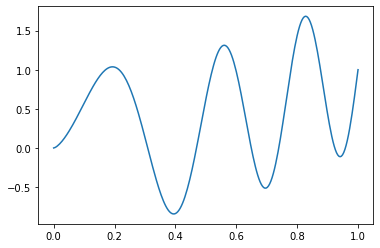

In [6]:
f=lambda X:np.sin(6*np.pi*np.abs(X)**(3/2))+X**2
n=256
X=np.linspace(0,1,n).reshape(1,n)
Y=f(X)
plt.plot(X[0,:],Y[0,:])
plt.show()

La fonction d'activation que nous allons utiliser est la fonction
$$x\mapsto \frac{1}{1+e^{-x}}$$
Implémentez cette fonction d'activation ainsi que sa dérivée dans la classe `Sigmoid`.



In [7]:
import Neural as Neur
L=Neur.Sigmoid()
x2=np.array([0,3,2])
print(L.forward(x2))
print(L.backward(x2))
# Vous devez trouver
# [0.5        0.95257413 0.88079708]
# (None, array([0.        , 0.13552998, 0.20998717]))

[0.5        0.95257413 0.88079708]
(None, array([0.        , 0.13552998, 0.20998717]))


# Approximation par réseau de neurones profond
Nous allons construire 2 réseaux de neurones, le premier, noté `N` sera une couche Dense de taille $(1,12)$ suivi d'une sigmoïde et d'une couche dense $(12,1)$. Ce réseau de Neurone sera l'approximation de notre fonction $f$. Nous allons aussi créer un réseau de neurone noté `N_a` qui sera `N` suivi d'une couche de perte en norme $L^2$. Nous nous servirons de `N_a` pour l'optimisation. Créez ces deux réseaux de neurones et utilisez `N_a` pour lancer un algorithme de gradient à pas fixe avec $2000$ itérations, en faisant attention à bien régler le pas (vous verrez c'est quasiment impossible). Votre algorithme doit sortir l'évolution de la fonction objectif le long des itérations. Vous afficherez aussi le plit des vraies données et des prédictions du réseau de Neurone.

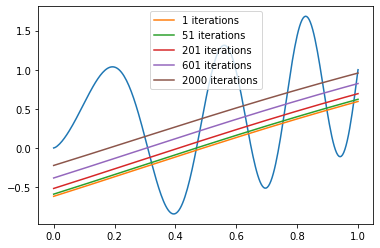

In [10]:
np.random.seed(13)
#on créé la solution exacte du problème
y=f(X)
#tableau de stockage des itérations
tabY=np.zeros((len(y[0]),2000))
#création des réseaux
N=Neur.Network([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Network([N,Neur.Loss_L2(y)])
#initialisation avec un theta aléatoire
theta=np.random.randn(N.nb_params)
N.set_params(theta)
#choix d'un pas
dt=1e-6
for i in range(2000):
    ycalc=N.forward(X)
    tabY[:,i]=ycalc
    deltaY=N_a.forward(X)
    grad=N_a.backward(None)[0]
    theta=theta-dt*grad
    N.set_params(theta)
    N_a.set_params(theta)
#affichage
plt.figure(1)
plt.plot(X[0,:],Y[0,:])
for i in [0,50,200,600,1999]:
    plt.plot(X[0,:],tabY[:,i],label=str(i+1)+" iterations")
plt.legend(loc="best")
plt.show()

Normalement vous ne devez pas avoir réussi à trouver le bon pas. Nous allons donc lancer un algorithme d'optimisation de `scipy` qui s'appelle `BFGS`. Si vous créez une fonction `func(u)` qui vous calcule le coût et une fonction `nablafunc(u)` qui vous rend le gradient de la fonction `func`, alors l'algorithme de `BFGS` que nous allons utiliser se lance avec :
`from scipy.optimize import minimize`
`res=minimize(func, u, method='BFGS', jac=nablafunc, options={'gtol': 1e-6, 'disp': True, 'maxiter': 2000})`
Dans le résultat `res`, il y a beaucoup d'information, mais le minimiseur est dans `res.x`.

         Current function value: 0.000177
         Iterations: 2000
         Function evaluations: 2224
         Gradient evaluations: 2224


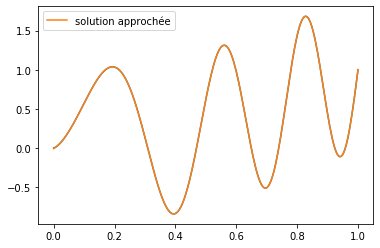

In [11]:
from scipy.optimize import minimize
np.random.seed(13)
N=Neur.Network([Neur.Dense(1,12),Neur.Sigmoid(),Neur.Dense(12,1)])
N_a=Neur.Network([N,Neur.Loss_L2(y)])


def func(u):
    N_a.set_params(u)
    return N_a.forward(X)

def nablafunc(u):
    N_a.set_params(u)
    N_a.forward(X)
    return N_a.backward(None)[0]

u=N_a.get_params()
res=minimize(func, u, method='BFGS', jac=nablafunc, options={'gtol': 1e-6, 'disp': True, 'maxiter': 2000})
u_opti=res.x
N_a.set_params(u_opti)
N.set_params(u_opti)
plt.plot(X[0],Y[0])
Y_calc=N.forward(X)
plt.plot(X[0],Y_calc[0],label="solution approchée")
plt.legend()
plt.show()